In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [24]:
import zipfile
import os

# Path to the zip file
zip_path = r"C:\Users\mca\Downloads\archive (11).zip"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_folder')  # This will create a folder called 'extracted_folder'

# Change to the extracted directory if necessary
os.chdir('extracted_folder')

# Run a specific script if needed (e.g., main.py)




In [27]:
import os
import re
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array

# Function to get files in proper alphanumeric order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

# Define image size
SIZE = 256
high_img = []

# Path for high-resolution images in extracted_folder
path =r"C:\Users\mca\Downloads\archive (11)\dataset\Raw Data\high_res"
files = os.listdir(path)
files = sorted_alphanumeric(files)

for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(os.path.join(path, i), 1)
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))

low_img = []

# Path for low-resolution images in extracted_folder
path = r"C:\Users\mca\Downloads\archive (11)\dataset\Raw Data\low_res"
files = os.listdir(path)
files = sorted_alphanumeric(files)

for i in tqdm(files):
    if i == '855.jpg':
        break
    else: 
        img = cv2.imread(os.path.join(path, i), 1)
        # Resize image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))


100%|███████████████████████████████████████████████████████████████████████████████| 855/855 [00:03<00:00, 221.45it/s]


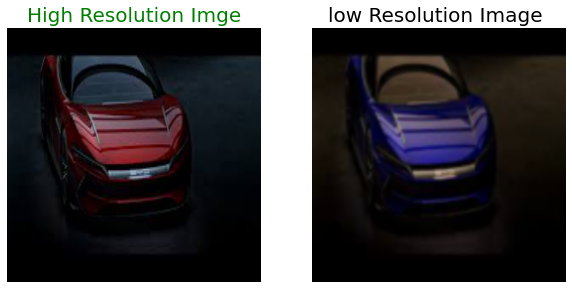

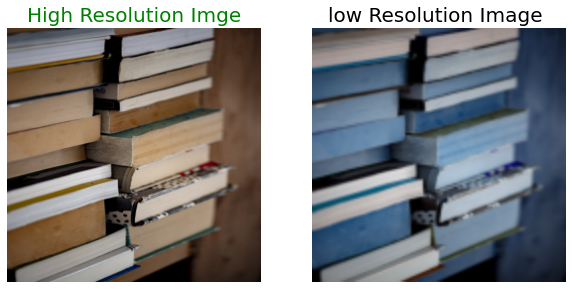

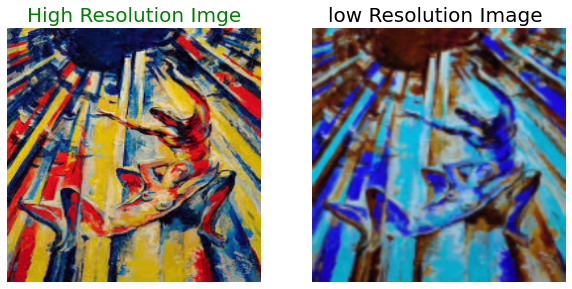

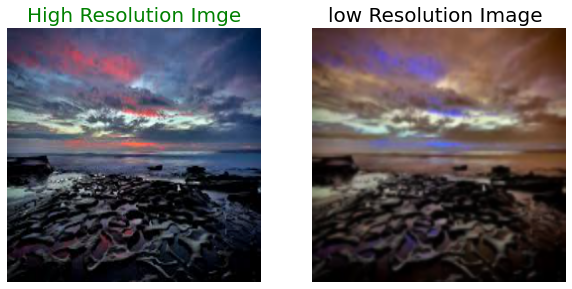

In [28]:
for i in range(4):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

In [29]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


In [30]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, Add, Lambda, ReLU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define the size and scale factor
SIZE = 256  # Desired image size
SCALE = 1  # Set scale to 1 (no change in resolution to match ground truth sizes)

# Function to build the EDSR model
def edsr_model(scale=SCALE):
    inputs = Input(shape=(SIZE, SIZE, 3))  # Fixed input size
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = ReLU()(x)

    # Add multiple residual blocks (e.g., 4 blocks here)
    for _ in range(4):
        res = x
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = ReLU()(x)
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = Add()([res, x])

    # Upsampling layers (identity upsampling to maintain original size)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = ReLU()(x)
    x = Conv2D(3, (3, 3), padding='same')(x)  # Output with 3 channels (RGB)

    return Model(inputs, x)

In [32]:
model = edsr_model(scale=2)  # Scale factor of 2
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='mean_absolute_error', metrics=['acc'])

In [33]:
model.fit(train_low_image, train_high_image, epochs = 5, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/5
700/700 ━━━━━━━━━━━━━━━━━━━━ 207s 294ms/step - acc: 0.6012 - loss: 0.0726 - val_acc: 0.7776 - val_loss: 0.0348
Epoch 2/5
700/700 ━━━━━━━━━━━━━━━━━━━━ 210s 300ms/step - acc: 0.7557 - loss: 0.0298 - val_acc: 0.7413 - val_loss: 0.0351
Epoch 3/5
700/700 ━━━━━━━━━━━━━━━━━━━━ 210s 300ms/step - acc: 0.7234 - loss: 0.0296 - val_acc: 0.8068 - val_loss: 0.0229
Epoch 4/5
700/700 ━━━━━━━━━━━━━━━━━━━━ 209s 299ms/step - acc: 0.7654 - loss: 0.0256 - val_acc: 0.7908 - val_loss: 0.0220
Epoch 5/5
700/700 ━━━━━━━━━━━━━━━━━━━━ 210s 301ms/step - acc: 0.7921 - loss: 0.0250 - val_acc: 0.8772 - val_loss: 0.0224


In [41]:
from skimage.metrics import structural_similarity as ssim

In [51]:
def calculate_sharpness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)  # Apply Laplacian
    variance = laplacian.var()  # Variance of the Laplacian
    return variance

# Function to plot images with sharpness


In [42]:
def calculate_psnr(img1, img2):
    """Calculate PSNR between two images."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  # If images are identical
    max_pixel = 1.0  # Since images are normalized
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_ssim(img1, img2):
    """Calculate SSIM between two images."""
    img1_gray = (img1 * 255).astype(np.uint8)
    img2_gray = (img2 * 255).astype(np.uint8)
    ssim_value, _ = ssim(img1_gray, img2_gray, full=True, multichannel=True)
    return ssim_value


In [43]:
def plot_images(high, low, predicted):
    plt.figure(figsize=(15, 15))

    plt.subplot(1, 3, 1)
    plt.title('High Image', color='green', fontsize=20)
    plt.imshow(high)

    plt.subplot(1, 3, 2)
    plt.title('Low Image', color='black', fontsize=20)
    plt.imshow(low)

    plt.subplot(1, 3, 3)
    plt.title('Predicted Image', color='red', fontsize=20)
    plt.imshow(predicted)

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Image 1: PSNR = 27.03 dB, SSIM = 0.9082


C:\Users\mca\AppData\Local\Temp\ipykernel_17296\916473460.py:14: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value, _ = ssim(img1_gray, img2_gray, full=True, multichannel=True)


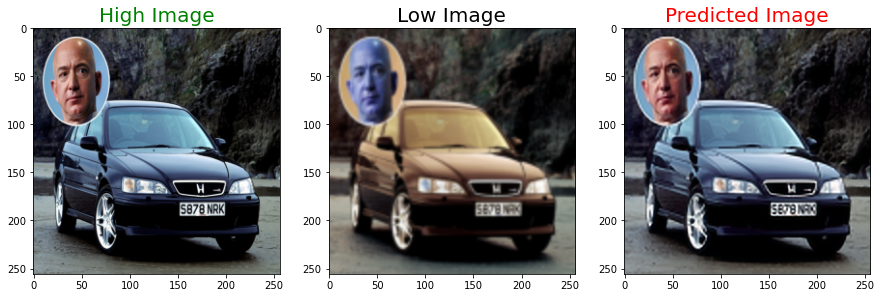

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Image 2: PSNR = 28.31 dB, SSIM = 0.8784


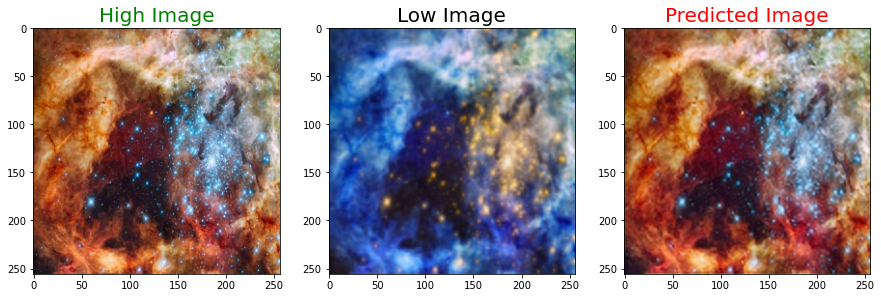

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Image 3: PSNR = 29.33 dB, SSIM = 0.9163


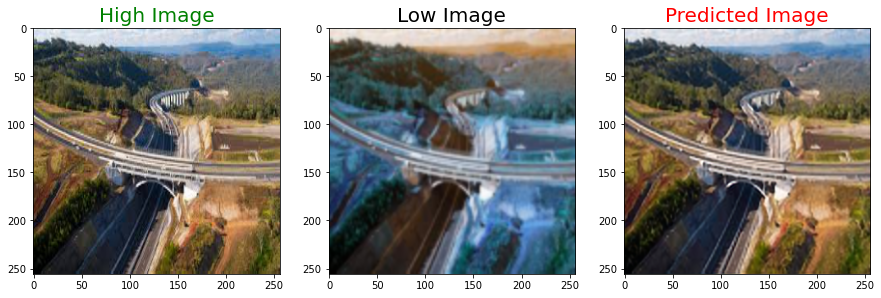

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Image 4: PSNR = 29.85 dB, SSIM = 0.9404


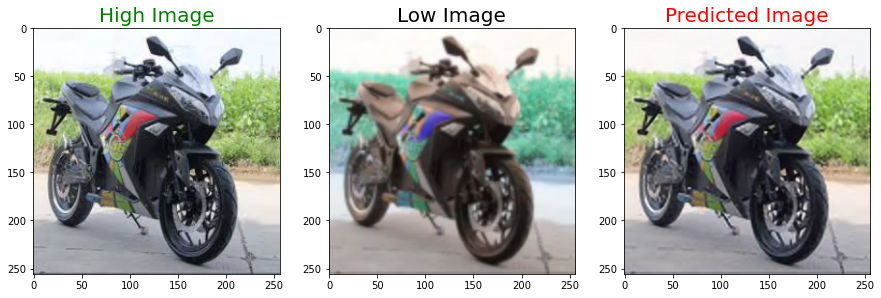

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Image 5: PSNR = 26.14 dB, SSIM = 0.8093


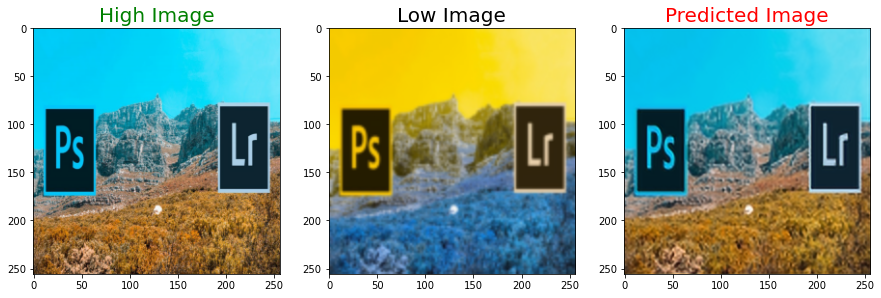

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Image 6: PSNR = 35.71 dB, SSIM = 0.9530


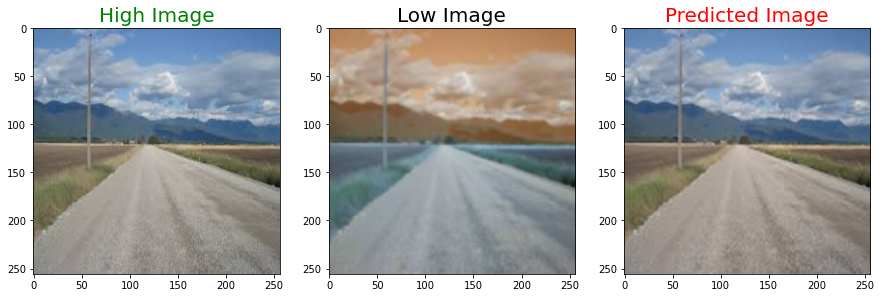

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Image 7: PSNR = 32.80 dB, SSIM = 0.9157


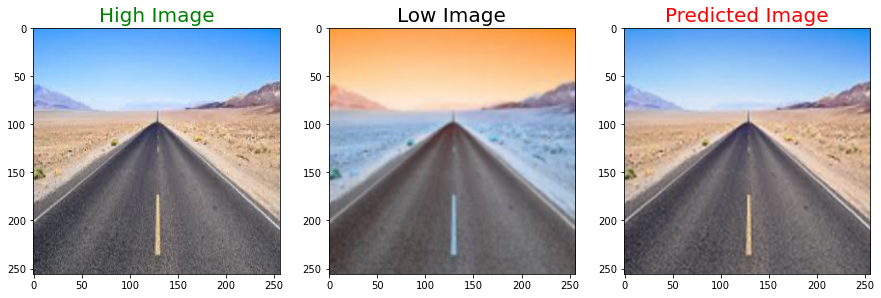

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Image 8: PSNR = 29.18 dB, SSIM = 0.8043


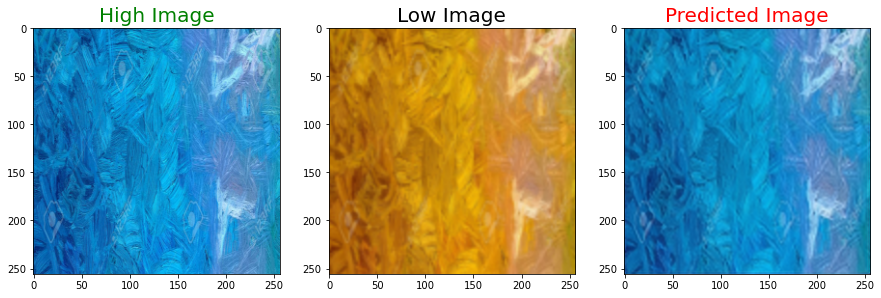

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Image 9: PSNR = 28.29 dB, SSIM = 0.9113


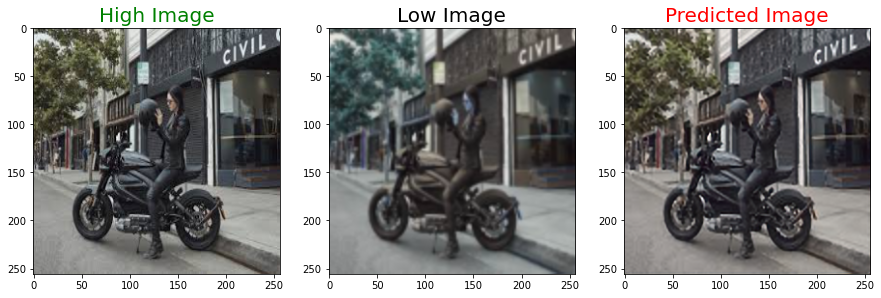

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Image 10: PSNR = 39.16 dB, SSIM = 0.9671


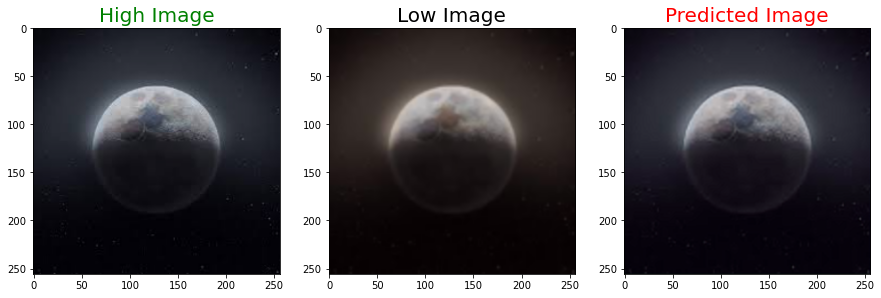

In [49]:
# Loop through test images and generate predictions
for i in range(1, 11):
    predicted = np.clip(model.predict(test_low_image[i].reshape(1, SIZE, SIZE, 3)), 0.0, 1.0).reshape(SIZE, SIZE, 3)
    
    # Calculate metrics
    psnr_value = calculate_psnr(test_high_image[i], predicted)
    ssim_value = calculate_ssim(test_high_image[i], predicted)

    # Print metrics
    print(f"Image {i}: PSNR = {psnr_value:.2f} dB, SSIM = {ssim_value:.4f}")
    
    # Plot images
    plot_images(test_high_image[i], test_low_image[i], predicted)


In [54]:
model.save("final_edsr_model.h5")